# 8-Puzzle

In [1]:
import random
import heapq
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from matplotlib import animation
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation

# N-Puzzle
N = 8

In [2]:
class Puzzle:
    parent = None
    state = None
    operator = None
    zero = None
    depth = 0
    cost = 0

    def __init__(self, state, parent=None, operator=None, depth=0):
        self.parent = parent
        self.state = np.array(state)
        self.operator = operator
        self.depth = depth
        self.zero = self.find_0()
        self.cost = self.depth + self.manhattan()

    def __lt__(self, other):
        if self.cost != other.cost:
            return self.cost < other.cost
        else:
            op_pr = {'Up': 0, 'Down': 1, 'Left': 2, 'Right': 3}
            return op_pr[self.operator] < op_pr[other.operator]

    def __str__(self):
        return str(self.state[:3]) + '\n' \
               + str(self.state[3:6]) + '\n' \
               + str(self.state[6:]) + ' ' + str(self.depth) + str(self.operator) + '\n'

    def goal_test(self):
        if np.array_equal(self.state, np.arange(9)):
            return True
        else:
            return False

    def find_0(self):
        for i in range(9):
            if self.state[i] == 0:
                return i

    def manhattan(self):
        state = self.index(self.state)
        goal = self.index(np.arange(9))
        return sum((abs(state // 3 - goal // 3) + abs(state % 3 - goal % 3))[1:])

    @staticmethod
    def index(state):
        index = np.array(range(9))
        for x, y in enumerate(state):
            index[y] = x
        return index

    def swap(self, i, j):
        new_state = np.array(self.state)
        new_state[i], new_state[j] = new_state[j], new_state[i]
        return new_state

    def up(self):
        if self.zero > 2:
            return Puzzle(self.swap(self.zero, self.zero - 3), self, 'Up', self.depth + 1)
        else:
            return None

    def down(self):
        if self.zero < 6:
            return Puzzle(self.swap(self.zero, self.zero + 3), self, 'Down', self.depth + 1)
        else:
            return None

    def left(self):
        if self.zero % 3 != 0:
            return Puzzle(self.swap(self.zero, self.zero - 1), self, 'Left', self.depth + 1)
        else:
            return None

    def right(self):
        if (self.zero + 1) % 3 != 0:
            return Puzzle(self.swap(self.zero, self.zero + 1), self, 'Right', self.depth + 1)
        else:
            return None

    def neighbors(self):
        neighbors = [self.up(), self.down(), self.left(), self.right()]
        return list(filter(None, neighbors))

    __repr__ = __str__

# A* Search

In [3]:
class Solver(ABC):
    solution = None
    frontier = None
    max_depth = 0
    nodes_expanded = 0
    initial_state = None
    explored_nodes = set()

    def __init__(self, initial_state):
        self.initial_state = initial_state

    def ancestral_chain(self):
        current = self.solution
        chain = [current]
        while current is not None and current.parent is not None:
            chain.append(current.parent)
            current = current.parent
        return chain

    @property
    def path(self):
        return [node.operator for node in self.ancestral_chain()[-2::-1]]

    @abstractmethod
    def solve(self):
        pass

    def set_solution(self, board):
        self.solution = board
        self.nodes_expanded = len(self.explored_nodes) - len(self.frontier) - 1


class AStar(Solver):
    def __init__(self, initial_state):
        super(AStar, self).__init__(initial_state)
        self.frontier = []

    def solve(self):
        heapq.heappush(self.frontier, self.initial_state)
        while self.frontier:
            board = heapq.heappop(self.frontier)
            self.explored_nodes.add(tuple(board.state))

            if board.goal_test():
                self.set_solution(board)
                break

            for neighbor in board.neighbors():
                if tuple(neighbor.state) not in self.explored_nodes:
                    heapq.heappush(self.frontier, neighbor)
                    self.explored_nodes.add(tuple(neighbor.state))
                    self.max_depth = max(self.max_depth, neighbor.depth)
        return

In [4]:
# number of cells
K = int((N + 1 + 1) ** 0.5)

# draw board in table format
def display_board(blocks):
    count, col = 0, 0
    edge = '+' + '-' * 3
    print(edge * K + '+')

    for num in blocks:
        if count == 3:
            print('|\n' + edge * K + '+')

            count = 0
            col += 1
            if col % K == 0:
                print(edge * K + '+')

        count += 1
        print('|', end=' ')
        print(num, end=' ')

    print('|\n' + edge * K + '+')

## Solution

In [5]:
def generate_board():
    board = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    random.shuffle(board)
    inversions = count_inversions(board)
    while inversions % 2 != 0:
        random.shuffle(board)
        inversions = count_inversions(board)
    return board


def count_inversions(board):
    inversions = 0
    for i in range(len(board)):
        for j in range(i + 1, len(board)):
            if board[i] > board[j] and board[i] != 0 and board[j] != 0:
                inversions += 1
    return inversions


# generate a solvable 8-puzzle board
initial_board = generate_board()
print('Initial state of game:')
display_board(initial_board)

solution_state = list(range(N + 1))
print('\nExpected final state:')
display_board(solution_state)

Initial state of game:
+---+---+---+
| 1 | 6 | 0 |
+---+---+---+
| 7 | 2 | 4 |
+---+---+---+
| 8 | 5 | 3 |
+---+---+---+

Expected final state:
+---+---+---+
| 0 | 1 | 2 |
+---+---+---+
| 3 | 4 | 5 |
+---+---+---+
| 6 | 7 | 8 |
+---+---+---+


In [6]:
# solve using A* Search
boards = Puzzle(initial_board)
solution = AStar(boards)

solution.solve()
print(f"Starting solving...\n")

# print details
if len(solution.path) > 0:
    print(f'Cost of Path:     {len(solution.path):,}')
    print(f'Nodes Expanded:   {solution.nodes_expanded:,}')
    print(f'Nodes Explored:   {len(solution.explored_nodes):,}')
    print(f'Search Depth:     {solution.solution.depth:,}')
    print(f'Max Search Depth: {solution.max_depth:,}')

    # print solution step
    print("\nPath to goal:")
    for i, step in enumerate(solution.path):
        if i != 0 and i % 10 == 0:
            print(step)
        else:
            print(step, end= " ")
else:
    print("There is no solution!")

Starting solving...

Cost of Path:     18
Nodes Expanded:   52
Nodes Explored:   89
Search Depth:     18
Max Search Depth: 18

Path to goal:
Down Left Up Right Down Down Left Left Up Right Right
Down Left Left Up Right Up Left 

## Create Animation

In [114]:
# Define the function to perform a move
def update_board(board, move):
    row, col = np.where(board == 0)
    new_row, new_col = row, col

    if move == 'Up':
        new_row = row - 1
    elif move == 'Down':
        new_row = row + 1
    elif move == 'Left':
        new_col = col - 1
    elif move == 'Right':
        new_col = col + 1

    # Invalid move, return the original board
    if new_row < 0 or new_row > 2 or new_col < 0 or new_col > 2:
        return board

    # Perform the move
    new_board = np.copy(board)
    new_board[row, col] = new_board[new_row, new_col]
    new_board[new_row, new_col] = 0
    return new_board


# Define a function to generate frames and text object
def generate_frames(solution):
    fig, ax = plt.subplots(figsize=(6, 6))

    labels = range(1, K + 1)
    plt.xticks(range(K), labels)
    plt.yticks(range(K), labels)

    frames = []
    all_texts = []

    board = np.reshape(initial_board, (K, K, 1))
    image = plt.imshow(board, animated=True)

    texts = []
    for (i, j), value in np.ndenumerate(board[:, :, 0]):
        if value != 0:
            text = ax.text(j, i, value, ha="center", va="center", fontsize=24)
            texts.append(text)

    all_texts.append(texts)
    frames.append([image])

    for move in solution:
        board = update_board(board[:, :, 0], move)
        board = np.reshape(board, (K, K, 1))
        image = plt.imshow(board, animated=True)

        # Clear the Text objects from the axes
        for text in texts:
            text.remove()

        # Add new Text objects for the current board
        texts = []
        for (i, j), value in np.ndenumerate(board[:, :, 0]):
            if value != 0:
                text = ax.text(j, i, value, ha="center", va="center", fontsize=24)
                texts.append(text)

        all_texts.append(texts)
        frames.append([image])

    return frames, all_texts


# Plot every solution steps
def create_animation(frames, texts):
    if len(frames) == 0:
        print("No solution found!")
        return

    num_frames = len(frames)
    rows = int(np.ceil(num_frames / 3))
    cols = min(3, num_frames)
    count = 0

    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 4 * rows))
    for i in range(rows):
        for j in range(cols):
            frame_idx = i * cols + j
            if frame_idx < num_frames:
                axs[i, j].imshow(frames[count][0].get_array())
                axs[i, j].set_title(f"Step {(count + 1)}")
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                for text_obj in texts[count]:
                    x, y = text_obj.get_position()
                    value = text_obj.get_text()
                    axs[i, j].text(x, y, value, ha="center", va="center", fontsize=24)
                count += 1
            else:
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])

    fig.tight_layout()
    
    # get image data and text positions from all subplots for each frame
    frames_and_texts = []
    for i in range(num_frames):
        frame_plot = axs[i // cols, i % cols].get_images()[0].get_array()
        text_objs  = axs[i // cols, i % cols].texts
        text_positions = []
        for text_obj in text_objs:
            x, y = text_obj.get_position()
            value = text_obj.get_text()
            text_positions.append({'x': x, 'y': y, 'text': value})
        frames_and_texts.append({'frame': frame_plot, 'text_positions': text_positions})

    # create animation
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(frames_and_texts[0]['frame'], animated=True)

    labels = range(1, K + 1)
    plt.xticks([])
    plt.yticks([])

    def update(frame):
        im.set_array(frame['frame'])
        ax.texts.clear()
        for obj in frame['text_positions']:
            x = obj['x']
            y = obj['y']
            text = obj['text']
            ax.text(x, y, text, ha='center', va='center', fontsize=24)
        return [im]

    anim = animation.FuncAnimation(
        fig, update, frames=frames_and_texts, interval=600, blit=True
    )
    return anim

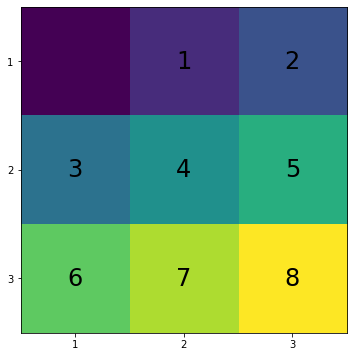

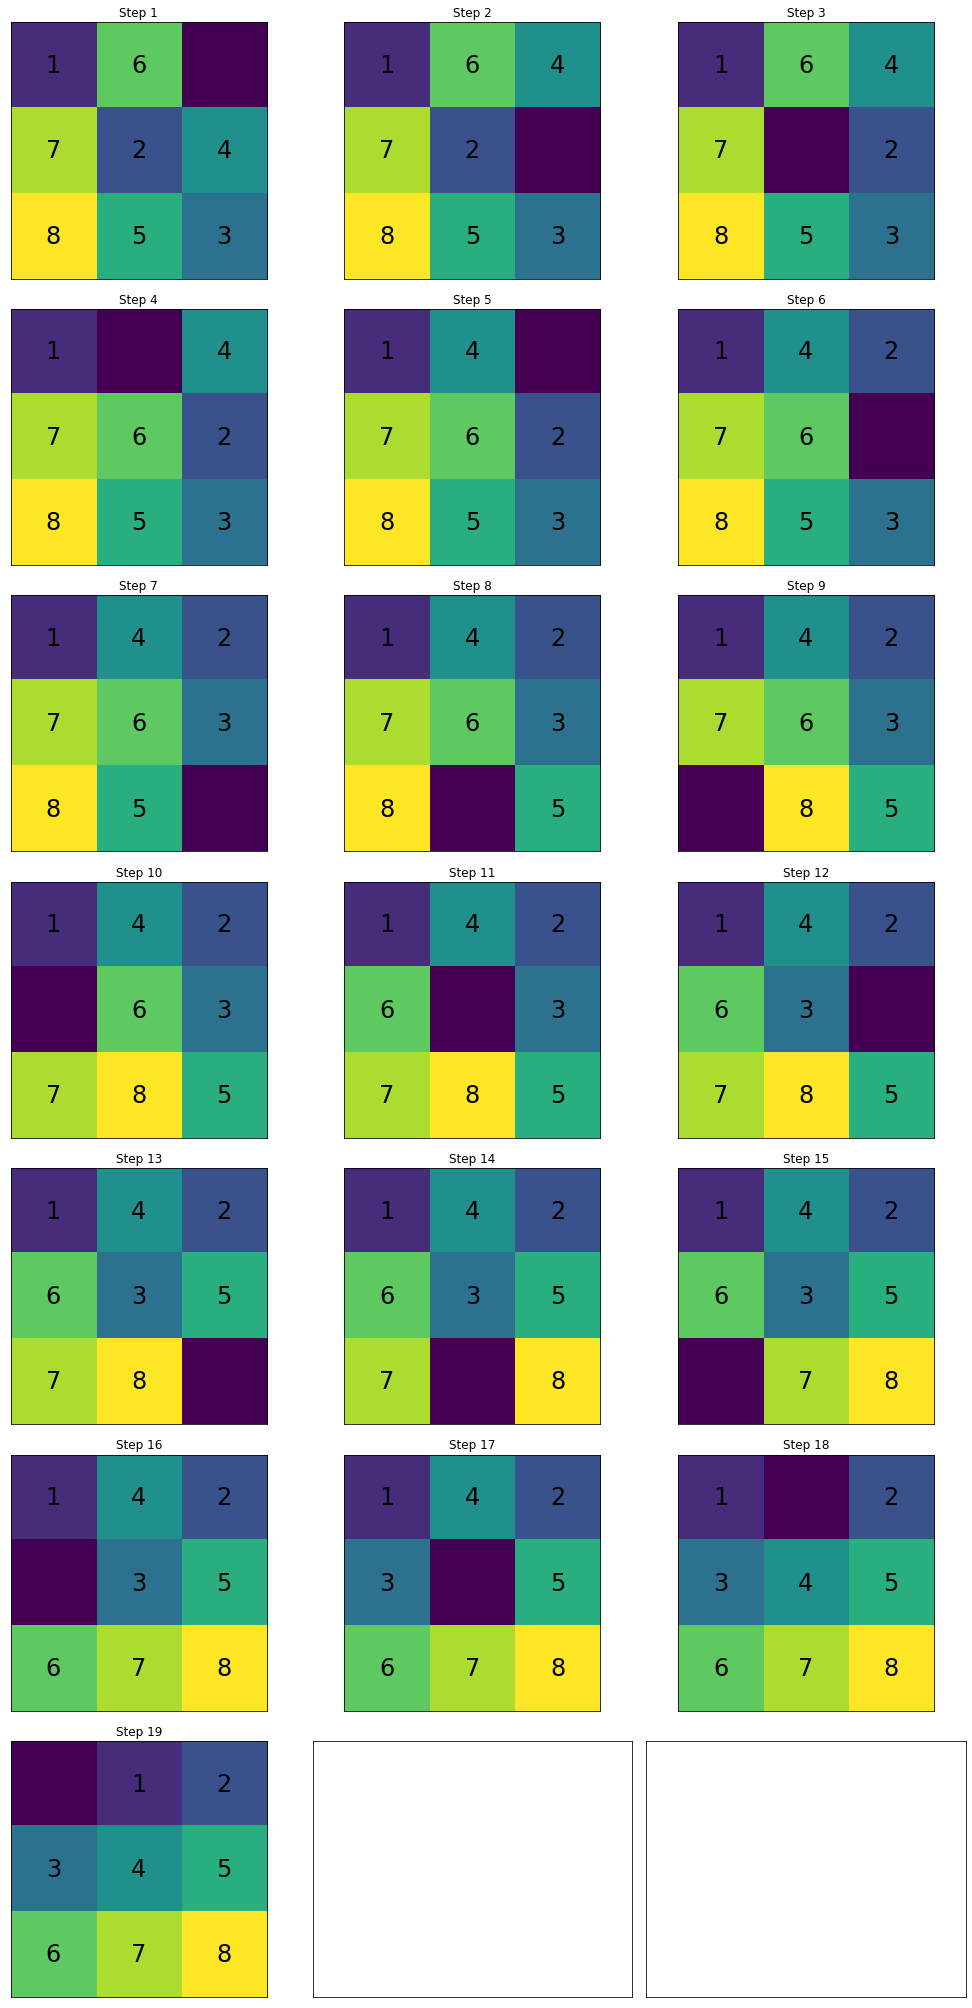

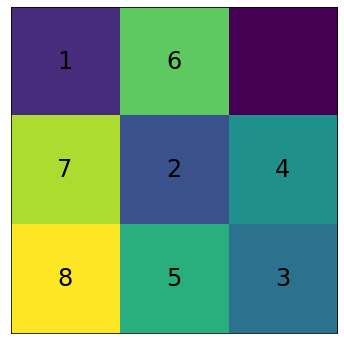

In [115]:
frames, texts = generate_frames(solution.path)
anim = create_animation(frames, texts)

In [116]:
# anim = animate_board(solution.path)
HTML(anim.to_html5_video())

In [117]:
# saving to animation gif file
anim.save('./assets/N_Puzzle.gif', writer='pillow')
plt.close()